In [1]:
# нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xmltodict
import openai
from tqdm import tqdm

##### Чистим датафрейм: идентификаторы, цены, валюты

###### Открываем датафрейм с нужными типами данных

In [2]:
# открываю таблицу с указанием типов данных
file_path = 'output_dataframe_cleaned_correct_datatype.csv'
dtype_dict = {'publish_date': 'string',
              'reason': 'string',
              'customer_code': 'string',
              'customer_inn': 'string',
              'customer_kpp': 'string',
              'supplier_full_name': 'string',
              'supplier_type': 'string',
              'supplier_inn': 'string',
              'supplier_kpp': 'string',
              'purchase_object': 'string',
              'contract_object': 'string',
              'contract_price_currency': 'string',
              'purchase_object': 'string'
             }  # словарь с типами данных для нужных столбцов
df = pd.read_csv(file_path, dtype=dtype_dict)

In [2]:
# нужные библиотеки
import pandas as pd

###### Разберемся с ИНН, КПП. Должно быть только 10 и 12 цифр, а по факту есть какие то выбросы

In [6]:
# Подсчитываем количество записей для каждой длины
# customer_inn
count_per_length_customer_inn = df['customer_inn'].str.len().value_counts().sort_index()
count_per_length_customer_inn

customer_inn
9      2624
10    60022
Name: count, dtype: Int64

In [7]:
# Подсчитываем количество записей для каждой длины
# customer_kpp
count_per_length_customer_kpp = df['customer_kpp'].str.len().value_counts().sort_index()
count_per_length_customer_kpp

customer_kpp
8     2637
9    60009
Name: count, dtype: Int64

In [8]:
# Подсчитываем количество записей для каждой длины
# supplier_inn
count_per_length_supplier_inn = df['supplier_inn'].str.len().value_counts().sort_index()
count_per_length_supplier_inn

supplier_inn
8         2
9        15
10    49378
11       32
12    13197
13       14
14        2
15        4
16        1
20        1
Name: count, dtype: Int64

In [9]:
# Подсчитываем количество записей для каждой длины
# supplier_kpp
count_per_length_supplier_kpp = df['supplier_kpp'].str.len().value_counts().sort_index()
count_per_length_supplier_kpp

supplier_kpp
1       18
8      896
9    35448
Name: count, dtype: Int64

Вывод:
1) для заказчика в ИНН и КПП не хватает 0 вначале. Надо добавить
2) для поставщика ИНН 8 знаков - это компании из Украины, у них свой идентификатор. Инсайт по 'supplier_type': возможно UF - это иностранная компания  
   В общем, их надо удалить. Мы их не смэтчим по спарку
3) для поставщика ИНН 9 знаков - это компании из Беларусии и просто неправильно заполенные данные по РФ компаниям. Наблюдений всего 15 - удаляем.
4) для поставщика ИНН 11 знаков - в основном это опечатки. 32 записи - немало, но придется удалить. Возможно указать об этом.
5) для поставщика ИНН 13 знаков - тоже фигня, не будем с этим разбираться, удаляем 14 записей
6) для поставщика ИНН 14 знаков - 2 значения, удаляем
7) для поставщика ИНН 15 знаков - 4 значения, удаляем
8) для поставщика ИНН 16 знаков - 1 значения, удаляем
9) для поставщика ИНН 20 знаков - 1 значения, удаляем
10) для поставщика КПП 1 знак - "0", значит нет КПП - заменить на None
11) для поставщика КПП 8 знаков - забыли 0 перед КПП, добавить

###### Приведем все ИНН и КПП к правильному формату

In [33]:
# customer_inn
# добавление '0' к значениям, где длина строки равна 8
df['customer_inn'] = df['customer_inn'].astype(str).apply(lambda x: '0' + x if len(x) == 9 else x).astype('string')

In [37]:
# customer_kpp
# добавление '0' к значениям, где длина строки равна 8
df['customer_kpp'] = df['customer_kpp'].astype(str).apply(lambda x: '0' + x if len(x) == 8 else x).astype('string')

In [39]:
# Оставляем только те строки, длина 'supplier_inn' которых равна 10 или 12 символов
df = df.loc[df['supplier_inn'].astype(str).apply(len).isin([10, 12])]

In [49]:
# suplier_kpp
# добавление '0' к значениям, где длина строки равна 8
df['supplier_kpp'] = df['supplier_kpp'].astype(str).apply(lambda x: '0' + x if len(x) == 8 else x).astype('string')

###### Приведем цены к рублю. Есть разные валюты. Их немного, сконвертируем вручную

USD

In [56]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2018) & (df['contract_price_currency'] == 'USD')
df.loc[condition, 'contract_price_amount'] *= 63 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

In [59]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2019) & (df['contract_price_currency'] == 'USD')
df.loc[condition, 'contract_price_amount'] *= 65 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

In [61]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2021) & (df['contract_price_currency'] == 'USD')
df.loc[condition, 'contract_price_amount'] *= 74 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

AUD

In [65]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2015) & (df['contract_price_currency'] == 'AUD')
df.loc[condition, 'contract_price_amount'] *= 46 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

In [67]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2016) & (df['contract_price_currency'] == 'AUD')
df.loc[condition, 'contract_price_amount'] *= 50 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

EUR

In [70]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2016) & (df['contract_price_currency'] == 'EUR')
df.loc[condition, 'contract_price_amount'] *= 74 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

In [72]:
# Изменение цены и валюты по условиям
condition = (df['publish_date_year'] == 2017) & (df['contract_price_currency'] == 'EUR')
df.loc[condition, 'contract_price_amount'] *= 66 # Изменяем цену
df.loc[condition, 'contract_price_currency'] = 'RUB'  # Изменяем валюту

In [75]:
df.to_csv('dataframe_final.csv', index=False)  # Индекс не сохраняем

#### Работа с чистым датафреймом

In [43]:
# открываю таблицу с указанием типов данных
file_path = 'dataframe_final.csv'
dtype_dict = {'publish_date': 'string',
              'reason': 'string',
              'customer_code': 'string',
              'customer_inn': 'string',
              'customer_kpp': 'string',
              'supplier_full_name': 'string',
              'supplier_type': 'string',
              'supplier_inn': 'string',
              'supplier_kpp': 'string',
              'purchase_object': 'string',
              'contract_object': 'string',
              'contract_price_currency': 'string',
              'purchase_object': 'string'
             }  # словарь с типами данных для нужных столбцов
df = pd.read_csv(file_path, dtype=dtype_dict)

##### Цены

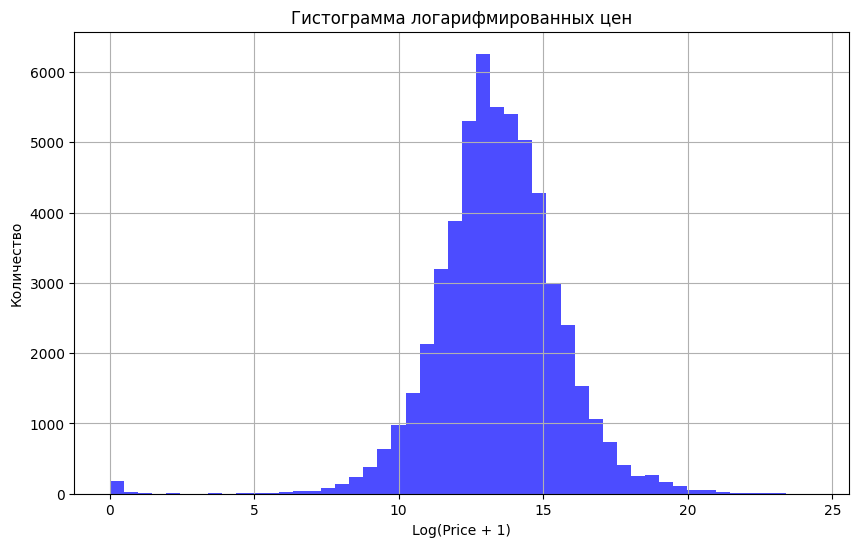

In [91]:
prices = df['contract_price_amount']

# Предположим, что prices - это ваш массив с ценами
prices = np.array(prices)  # Преобразование списка в массив NumPy, если это еще не сделано
log_prices = np.log(prices + 1)  # Логарифмирование цен, +1 чтобы избежать log(0)

plt.figure(figsize=(10, 6))
plt.hist(log_prices, bins=50, color='blue', alpha=0.7)
plt.title('Гистограмма логарифмированных цен')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [92]:
prices = df['contract_price_amount']
print("Минимальная цена:", np.min(prices))
print("Максимальная цена:", np.max(prices))
print("Средняя цена:", np.mean(prices))
print("Медиана цен:", np.median(prices))
print("Стандартное отклонение:", np.std(prices))
print("Квартили:", np.percentile(prices, [25, 50, 75]))

print("Медиана цен (игнорируя NaN):", np.nanmedian(prices))
print("Квартили (игнорируя NaN):", np.nanpercentile(prices, [25, 50, 75]))

Минимальная цена: 0.0
Максимальная цена: 38477099159.82
Средняя цена: 12857152.103595693
Медиана цен: nan
Стандартное отклонение: 314504321.19325125
Квартили: [nan nan nan]
Медиана цен (игнорируя NaN): 660475.235
Квартили (игнорируя NaN): [ 200273.745  660475.235 2387192.25 ]


##### Годы

In [94]:
df['publish_date_year'].value_counts()

publish_date_year
2021    12414
2020    10808
2019    10104
2018     6364
2015     5584
2017     5295
2016     4883
2022     3807
2014     3316
Name: count, dtype: int64

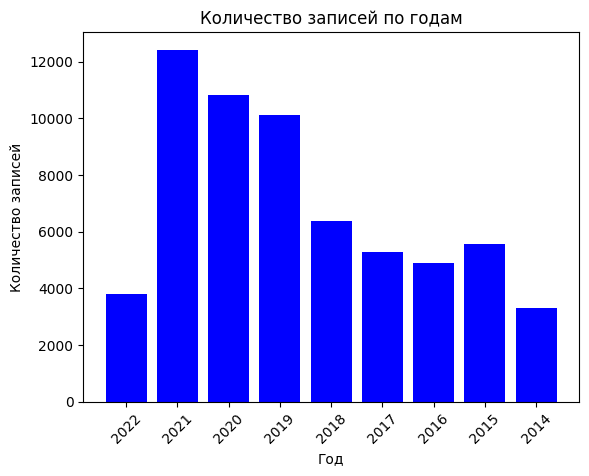

In [96]:
publish_count = df['publish_date_year'].value_counts().sort_index(ascending=False)

# Создаем гистограмму
plt.bar(publish_count.index.astype(str), publish_count.values, color='blue')

# Настройка визуализации
plt.xlabel('Год')
plt.ylabel('Количество записей')
plt.title('Количество записей по годам')
plt.xticks(rotation=45)  # Поворачиваем метки на оси X для лучшей читаемости

# Показываем гистограмму
plt.show()

##### Компании и ИП

In [97]:
# Подсчитываем количество записей для каждой длины
count_per_length = df['supplier_inn'].str.len().value_counts().sort_index()
count_per_length

supplier_inn
10    49378
12    13197
Name: count, dtype: Int64

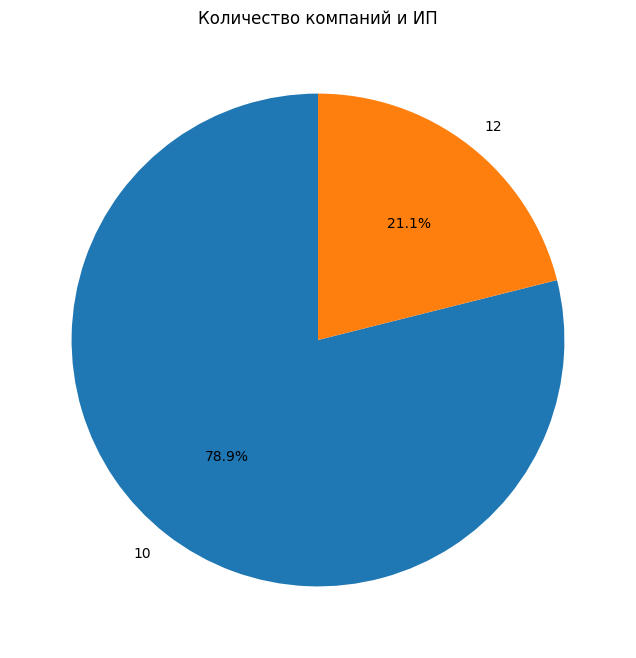

In [99]:
# Создаем круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(count_per_length, labels=count_per_length.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('Количество компаний и ИП')
plt.show()

In [24]:
# Получаем количество каждого уникального значения в столбце
value_counts = df['supplier_inn'].value_counts()

# Фильтруем значения, которые встречаются только один раз
value_counts[value_counts == 1]

Series([], Name: count, dtype: Int64)

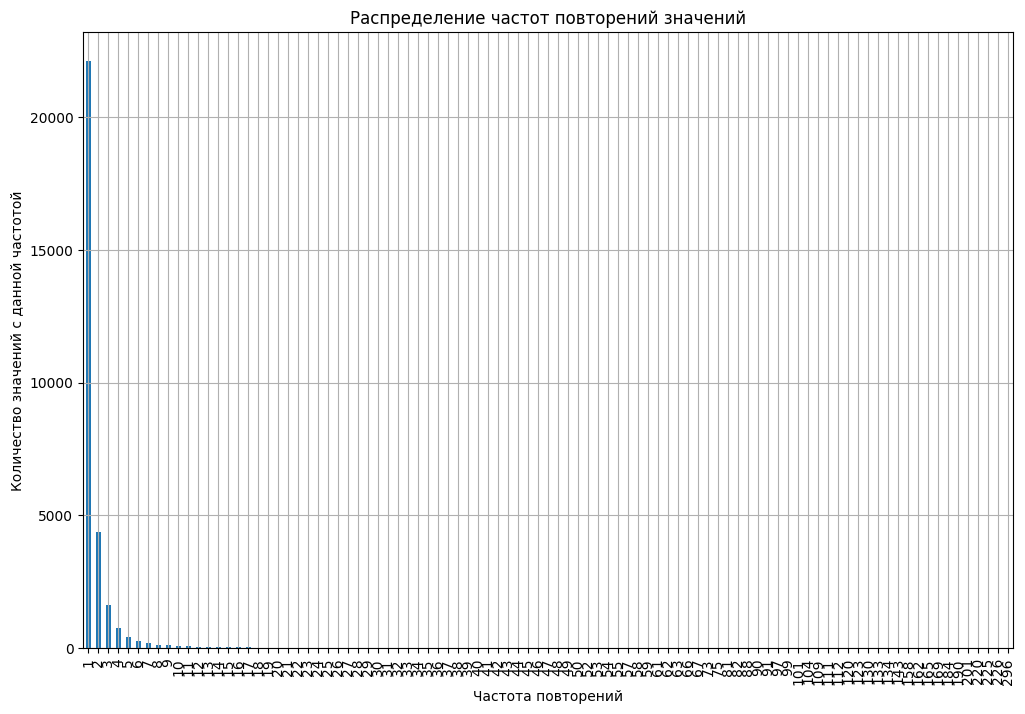

In [26]:
column = df['supplier_inn']

# Получаем количество каждого уникального значения в столбце
value_counts = column.value_counts()

# Получаем распределение частот повторений
frequency_distribution = value_counts.value_counts().sort_index()

plt.figure(figsize=(12, 8))
frequency_distribution.plot(kind='bar')
plt.title('Распределение частот повторений значений')
plt.xlabel('Частота повторений')
plt.ylabel('Количество значений с данной частотой')
plt.grid(True)
plt.show()

 количество различных частот очень велико, график может стать перегруженным. В таком случае можно использовать логарифмический масштаб для осей:

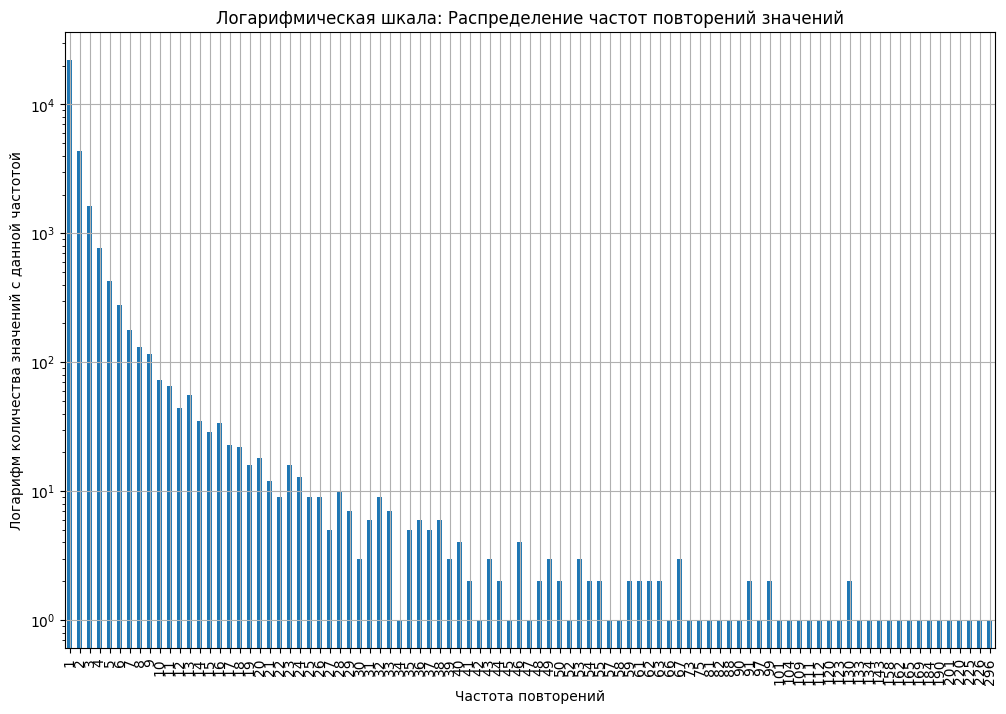

In [27]:
plt.figure(figsize=(12, 8))
frequency_distribution.plot(kind='bar', logy=True)
plt.title('Логарифмическая шкала: Распределение частот повторений значений')
plt.xlabel('Частота повторений')
plt.ylabel('Логарифм количества значений с данной частотой')
plt.grid(True)
plt.show()

In [ ]:
df['supplier_inn'].hist(bins=50, figsize=(10, 8))
plt.title('Гистограмма распределения значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

#### Пробуем смэтчить со СПАРК

In [6]:
# Чтение данных
csv_data = pd.read_csv('dataframe_final.csv') 
excel_data = pd.read_excel('spark_test.xlsx')  

# Объединение данных
result = pd.merge(csv_data, excel_data, left_on='supplier_inn', right_on='Код налогоплательщика', how='left')

,publish_date_year,publish_date,reason,customer_code,customer_inn,customer_kpp,supplier_full_name,supplier_type,supplier_inn,supplier_kpp,...,"2014, Коэффициент обеспеченности собственными оборотными средствами, %","2014, Коэффициент концентрации заемного капитала,%","2014, Чистая норма прибыли, %","2014, Рентабельность продаж, %","2014, Рентабельность активов (ROA), %","2014, Рентабельность капитала (ROE), %","2014, Коэффициент текущей ликвидности, %","2014, Доля краткосрочной в общем объеме задолженности, %","2014, Коэффициент быстрой ликвидности, %","2014, Коэффициент абсолютной ликвидности, %"
0,2014,2014-01-21 14:22:11.636,CANCEL_CONTRACT,3243000884,2901056972,290101001,"ООО ""Строительные технологии""",U,2901235160,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,2014-01-24 15:47:55.179,CANCEL_CONTRACT,1572000045,6027087514,602701001,"ООО ""РОСПРОМТОРГ""",U,6321299175,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2014-01-24 17:00:36.339,CANCEL_CONTRACT,3172000228,2225022328,222501001,"Общество с ограниченной ответственностью ""Гермес""",U,2225097612,222501001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,2014-01-27 11:59:04.391,CANCEL_CONTRACT,1731000147,7701903677,770101001,"ООО ""АктивСтройСервис""",U,7728800929,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,2014-01-27 12:17:33.049,CANCEL_CONTRACT,6351000001,3908005986,390601001,"Общество с ограниченной ответственностью ""ПЕГАС""",U,7713754973,771301001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62570,2018,2018-03-01,CANCEL_CONTRACT,1373000229,4003005597,400301001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОПТО...",U,4025419633,402501001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62571,2018,2018-03-01,CANCEL_CONTRACT,1463000090,4826021756,482601001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ТРИУМФ""",U,1215214501,121501001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62572,2018,2018-02-19,WINNER_DEVIATION,8104000013,1510018007,151001001,"ООО ""Т-2""",U,5022030921,502201001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62573,2018,2018-02-19,WINNER_DEVIATION,3483005360,5043007144,504301001,ООО «Биосфера»,U,6234117365,623401001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
result.to_csv('merged_data.csv', index=False)

Вывод:
1) мэтчинг получился
2) но одной итерацией мы захватили только мизерную часть наблюдений
3) поэтому надо пытаться иначе

#### Работа с видом деятельности. Классификация

In [3]:
# открываю таблицу с указанием типов данных
file_path = 'dataframe_final_and_clear_object.csv'
dtype_dict = {'publish_date': 'string',
              'reason': 'string',
              'customer_code': 'string',
              'customer_inn': 'string',
              'customer_kpp': 'string',
              'supplier_full_name': 'string',
              'supplier_type': 'string',
              'supplier_inn': 'string',
              'supplier_kpp': 'string',
              'purchase_object': 'string',
              'contract_object': 'string',
              'contract_price_currency': 'string',
              'purchase_object': 'string'
             }  # словарь с типами данных для нужных столбцов
df = pd.read_csv(file_path, dtype=dtype_dict)

C:\Users\ww\AppData\Local\Temp\ipykernel_19196\3356673362.py:17: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, dtype=dtype_dict)


In [5]:
df.dtypes

publish_date_year                   int64
publish_date               string[python]
reason                     string[python]
customer_code              string[python]
customer_inn               string[python]
customer_kpp               string[python]
supplier_full_name         string[python]
supplier_type              string[python]
supplier_inn               string[python]
supplier_kpp               string[python]
founders_inn_role                  object
purchase_object            string[python]
contract_object            string[python]
contract_price_currency    string[python]
contract_price_amount             float64
final_object                       object
clean_object                       object
dtype: object

In [28]:
# Проверка заполненности столбцов
total_entries = len(df)
non_null_purchase = df['purchase_object'].notna().sum()
non_null_contract = df['contract_object'].notna().sum()

print(f"Заполненность столбца purchase_object: {non_null_purchase} из {total_entries}")
print(f"Заполненность столбца contract_object: {non_null_contract} из {total_entries}")

# Подсчет случаев, когда X заполнен, а Y нет, и наоборот
purchase_filled_contract_empty = ((df['purchase_object'].notna()) & (df['contract_object'].isna())).sum()
contract_filled_purchase_empty = ((df['contract_object'].notna()) & (df['purchase_object'].isna())).sum()

print(f"Случаев, когда purchase заполнен, а contract нет: {purchase_filled_contract_empty}")
print(f"Случаев, когда contract заполнен, а purchase нет: {contract_filled_purchase_empty}")

Заполненность столбца purchase_object: 58274 из 62575
Заполненность столбца contract_object: 55127 из 62575
Случаев, когда purchase заполнен, а contract нет: 6563
Случаев, когда contract заполнен, а purchase нет: 3416


In [29]:
df['final_object'] = df['contract_object'].combine_first(df['purchase_object'])

In [31]:
df.to_csv('dataframe_final.csv', index=False)  # Индекс не сохраняем

In [37]:
df['final_object'].isna().sum()

885

In [ ]:
"1) Сельское, лесное хозяйство, охота, рыболовство и рыбоводство\n"
"2) Добыча полезных ископаемых\n"
"3) Обрабатывающие производства\n"
"4) Обеспечение электрической энергией, газом и паром; кондиционирование воздуха\n"
"5) Водоснабжение; водоотведение, организация сбора и утилизации отходов, деятельность по ликвидации загрязнений\n"
"6) Строительство\n"
"7) Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов\n"
"8) Транспортировка и хранение\n"
"9) Деятельность гостиниц и предприятий общественного питания\n"
"10) Деятельность в области информации и связи\n"
"11) Деятельность финансовая и страховая\n"
"12) Деятельность по операциям с недвижимым имуществом\n"
"13) Деятельность профессиональная, научная и техническая\n"
"14) Деятельность административная и сопутствующие дополнительные услуги\n"
"15) Государственное управление и обеспечение военной безопасности; социальное обеспечение\n"
"16) Образование\n"
"17) Деятельность в области здравоохранения и социальных услуг\n"
"18) Деятельность в области культуры, спорта, организации досуга и развлечений\n"
"19) Предоставление прочих видов услуг\n"
"20) Деятельность домашних хозяйств как работодателей; недифференцированная деятельность частных домашних хозяйств по производству товаров и оказанию услуг для собственного потребления\n"
"21) Деятельность экстерриториальных организаций и органов"

In [16]:
tqdm.pandas()

openai.api_key = '...' # индивидуальный ключ для API

def classify_purchase(description):
    try:
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",  
            prompt=f"К какому виду деятельности относится следующее описание закупки? '{description}'
                \n\n1) Сельское, лесное хозяйство, охота, рыболовство и рыбоводство\n
                    2) Добыча полезных ископаемых\n
                    3) Обрабатывающие производства\n
                    4) Обеспечение электрической энергией, газом и паром; кондиционирование воздуха\n
                    5) Водоснабжение; водоотведение, организация сбора и утилизации отходов, деятельность по ликвидации загрязнений\n
                    6) Строительство\n
                    7) Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов\n
                    8) Транспортировка и хранение\n
                    9) Деятельность гостиниц и предприятий общественного питания\n
                    10) Деятельность в области информации и связи\n
                    11) Деятельность финансовая и страховая\n
                    12) Деятельность по операциям с недвижимым имуществом\n
                    13) Деятельность профессиональная, научная и техническая\n
                    14) Деятельность административная и сопутствующие дополнительные услуги\n
                    15) Государственное управление и обеспечение военной безопасности; социальное обеспечение\n
                    16) Образование\n
                    17) Деятельность в области здравоохранения и социальных услуг\n
                    18) Деятельность в области культуры, спорта, организации досуга и развлечений\n
                    19) Предоставление прочих видов услуг\n
                    20) Деятельность домашних хозяйств как работодателей; недифференцированная деятельность частных домашних хозяйств по производству товаров и оказанию услуг для собственного потребления\n
                    21) Деятельность экстерриториальных организаций и органов\n Если нет точной информации, выведи 'Нет ответа'",
            temperature=0,
            max_tokens=100
        )
        result = response.choices[0].text.strip()
        return result.split(') ')[1] if ') ' in result else result
    except Exception as e:
        print(f"Error: {e}")
        return "Classification Error"

df['clean_object'] = df['final_object'].progress_apply(classify_purchase)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [29:20<00:00,  1.42it/s]


In [18]:
df.to_csv('dataframe_final_and_clear_object_5.csv', index=False)  # Индекс не сохраняем

Объединим все результаты классификации в один датасет

In [33]:
# Загружаем базовый файл
base_df = pd.read_csv('dataframe_final_and_clear_object.csv')

# Список для остальных файлов
other_files = ['dataframe_final_and_clear_object_2.csv', 'dataframe_final_and_clear_object_3.csv', 'dataframe_final_and_clear_object_4.csv',
               'dataframe_final_and_clear_object_5.csv']

# Загружаем данные из остальных файлов и добавляем их столбцы 'clean_object' к базовому DataFrame
for i, file in enumerate(other_files, start=1):
    other_df = pd.read_csv(file, usecols=['clean_object'])
    base_df[f'clean_object_{i}'] = other_df['clean_object']

# Функция для объединения столбцов 'clean_object'
def combine_clean_objects(row):
    for col in row.index:
        if not pd.isna(row[col]):
            return row[col]
    return None

# Создаем новый столбец 'combined_clean_object' с объединенными значениями
base_df['combined_clean_object'] = base_df[['clean_object'] + [f'clean_object_{i}' for i in range(1, 5)]].apply(combine_clean_objects, axis=1)

C:\Users\ww\AppData\Local\Temp\ipykernel_10472\2620191374.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv('dataframe_final_and_clear_object.csv')
C:\Users\ww\AppData\Local\Temp\ipykernel_10472\2620191374.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  other_df = pd.read_csv(file, usecols=['clean_object'])
C:\Users\ww\AppData\Local\Temp\ipykernel_10472\2620191374.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  other_df = pd.read_csv(file, usecols=['clean_object'])
C:\Users\ww\AppData\Local\Temp\ipykernel_10472\2620191374.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  other_df = pd.read_csv(file, usecols=['clean_object'])
C:\Users\ww\AppData\Local\Temp\ipykernel_10472\2620191374.py:10: DtypeWarning: Columns (16) have mixed

In [37]:
base_df.to_csv('dataframe_final_and_clear_object_combined.csv', index=False)

In [47]:
base_df['combined_clean_object'].value_counts()

combined_clean_object
Строительство                                                                                                   1694
Деятельность административная и сопутствующие дополнительные услуги                                              846
Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов                                       664
Нет ответа                                                                                                       519
Деятельность в области здравоохранения и социальных услуг                                                        474
Деятельность профессиональная, научная и техническая                                                             445
Обеспечение электрической энергией, газом и паром; кондиционирование воздуха                                     210
Транспортировка и хранение                                                                                       195
Сельское, лесное хозяйство, охота, рыболов

#### Работа со СПАРК

In [34]:
# проверим структуру xml файла
with open('010104859805.xml', encoding="utf8") as datafile:
    test_010104859805 = xmltodict.parse(datafile.read())

In [22]:
company_info_test # company_info_spark 

{'Response': {'Data': {'Report': {'@ActualDate': '2024-04-05',
    'SparkID': '10500009',
    'CompanyType': '1',
    'Status': {'@IsActing': '1',
     '@Code': '24',
     '@Type': 'Действующее',
     '@GroupId': '1',
     '@GroupName': 'Действующее',
     '@Date': '2024-04-05'},
    'EGRPOIncluded': 'true',
    'IsActing': 'true',
    'DateFirstReg': '2016-03-23',
    'ShortNameRus': 'ООО "МЕМОРИАЛ-СЕРВИС № 1"',
    'ShortNameEn': 'OOO "MEMORIAL-SERVIS N 1"',
    'FullNameRus': 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "МЕМОРИАЛ-СЕРВИС № 1"',
    'NormName': 'МЕМОРИАЛ-СЕРВИС № 1, ООО',
    'GUID': 'CD8F64716CD14732A36681FC354946B0',
    'INN': '7447260178',
    'KPP': '745101001',
    'OGRN': '1167456068944',
    'OKPO': '01290425',
    'OKATO': {'@Code': '75401376000',
     '@RegionName': 'Челябинская область',
     '@RegionCode': '75'},
    'OKTMO': {'@Code': '75701370000'},
    'OKOGU': {'@Code': '4210014',
     '@Name': 'Организации, учрежденные юридическими лицами или гражданами,

In [27]:
company_info_test_2 # company_info_spark_2

{'Response': {'Data': {'Report': {'SparkID': '46',
    'ShortName': 'СТД РФ, СТД РФ (ВТО), СОЮЗ ТЕАТРАЛЬНЫХ ДЕЯТЕЛЕЙ РОССИЙСКОЙ ФЕДЕРАЦИИ',
    'INN': '7707035201',
    'OGRN': '1027700084576',
    'OKPO': '00021002',
    'EGRPOIncluded': 'true',
    'Period': {'@PeriodName': '2022',
     '@DateBegin': '2022-01-01',
     '@DateEnd': '2022-12-31',
     '@OKVEDCode': '94.12',
     '@ReportType': '3',
     '@LoadDate': '2023-03-06',
     'Form': [{'@ID': '1',
       '@Power': '1000',
       'Value': [{'@Code': '1110',
         '@Name': 'Нематериальные активы',
         '@Column': '3',
         '#text': '41'},
        {'@Code': '1110',
         '@Name': 'Нематериальные активы',
         '@Column': '4',
         '#text': '41'},
        {'@Code': '1110',
         '@Name': 'Нематериальные активы',
         '@Column': '5',
         '#text': '5'},
        {'@Code': '1150',
         '@Name': 'Основные средства',
         '@Column': '3',
         '#text': '19470'},
        {'@Code': '1150',
     

In [29]:
ip_info_test # ip_info_spark

{'Response': {'Data': {'Report': {'SparkID': '37000833',
    'Status': {'@IsActing': '1',
     '@Code': '24',
     '@Text': 'Действующее',
     '@GroupId': '1',
     '@GroupName': 'Действующее',
     '@Date': '2011-06-29'},
    'DateReg': '2011-06-29',
    'FullNameRus': 'Козлов Андрей Владимирович',
    'INN': '773204378093',
    'OGRNIP': '311774618000541',
    'OKPO': '0117439320',
    'OKATO': {'@Code': '45268584000',
     '@RegionName': 'Москва',
     '@RegionCode': '45'},
    'OKTMO': {'@Code': '45325000000'},
    'OKOPF': {'@Code': '50102', '@Name': 'Индивидуальные предприниматели'},
    'OKVED2List': {'OKVED': [{'@Code': '68.20.2',
       '@Name': 'Аренда и управление собственным или арендованным нежилым недвижимым имуществом',
       '@IsMain': 'true'},
      {'@Code': '41.10', '@Name': 'Разработка строительных проектов'},
      {'@Code': '47.11',
       '@Name': 'Торговля розничная преимущественно пищевыми продуктами, включая напитки, и табачными изделиями в неспециализирован

In [3]:
test_0101004989

{'Response': {'Data': {'Report': {'@ActualDate': '2024-04-18',
    'SparkID': '4390855',
    'CompanyType': '1',
    'Status': {'@IsActing': '1',
     '@Code': '24',
     '@Type': 'Действующее',
     '@GroupId': '1',
     '@GroupName': 'Действующее',
     '@Date': '2024-04-18'},
    'EGRPOIncluded': 'true',
    'IsActing': 'true',
    'DateFirstReg': '2004-05-20',
    'ShortNameRus': 'ООО "ДОМОСТРОЙ"',
    'ShortNameEn': 'OOO "DOMOSTROI"',
    'FullNameRus': 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ДОМОСТРОЙ"',
    'NormName': 'ДОМОСТРОЙ, ООО',
    'GUID': '248E0CF035794483B55915C4ACF61B4E',
    'INN': '0101004989',
    'KPP': '010101001',
    'OGRN': '1040100509283',
    'OKPO': '72615960',
    'OKATO': {'@Code': '79205000007',
     '@RegionName': 'Адыгея (Республика) (Адыгея)',
     '@RegionCode': '79'},
    'OKTMO': {'@Code': '79605410101'},
    'OKOGU': {'@Code': '4210014',
     '@Name': 'Организации, учрежденные юридическими лицами или гражданами, или юридическими лицами и гражд

In [6]:
test_0101004989['Response']['Data']['Report']

{'@ActualDate': '2024-04-18',
 'SparkID': '4390855',
 'CompanyType': '1',
 'Status': {'@IsActing': '1',
  '@Code': '24',
  '@Type': 'Действующее',
  '@GroupId': '1',
  '@GroupName': 'Действующее',
  '@Date': '2024-04-18'},
 'EGRPOIncluded': 'true',
 'IsActing': 'true',
 'DateFirstReg': '2004-05-20',
 'ShortNameRus': 'ООО "ДОМОСТРОЙ"',
 'ShortNameEn': 'OOO "DOMOSTROI"',
 'FullNameRus': 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ДОМОСТРОЙ"',
 'NormName': 'ДОМОСТРОЙ, ООО',
 'GUID': '248E0CF035794483B55915C4ACF61B4E',
 'INN': '0101004989',
 'KPP': '010101001',
 'OGRN': '1040100509283',
 'OKPO': '72615960',
 'OKATO': {'@Code': '79205000007',
  '@RegionName': 'Адыгея (Республика) (Адыгея)',
  '@RegionCode': '79'},
 'OKTMO': {'@Code': '79605410101'},
 'OKOGU': {'@Code': '4210014',
  '@Name': 'Организации, учрежденные юридическими лицами или гражданами, или юридическими лицами и гражданами совместно'},
 'OKFS': {'@Code': '16', '@Name': 'Частная собственность'},
 'OKOPF': {'@Code': '65',
  '@Co

In [33]:
reg_date_spark = test_0101004989['Response']['Data']['Report']['DateFirstReg']
shortname_spark = test_0101004989['Response']['Data']['Report']['ShortNameRus']
inn_spark = test_0101004989['Response']['Data']['Report']['INN']
kpp_spark = test_0101004989['Response']['Data']['Report']['KPP']
region_name_spark = test_0101004989['Response']['Data']['Report']['OKATO']['@RegionName']
region_code_spark = test_0101004989['Response']['Data']['Report']['OKATO']['@RegionCode']
main_okved_code_spark = test_0101004989['Response']['Data']['Report']['OKVED2List']['OKVED'][0]['@Code']
main_okved_name_spark = test_0101004989['Response']['Data']['Report']['OKVED2List']['OKVED'][0]['@Name']
leader_list_spark = test_0101004989['Response']['Data']['Report']['LeaderList']['Leader'] # в примере только один лидер, но думаю может быть несколько, поэтому вывожу полный словарь
employees_spark = test_0101004989['Response']['Data']['Report']['StaffNumberFTS']['Number'] # кол-во сотрудников за 2017-2022 года, словарь
comp_type_spark = test_0101004989['Response']['Data']['Report']['IncludeInList']['ListName']['AddInfo']['AddField'][2]['#text']
test_0101004989['Response']['Data']['Report']['Finance']

{'@BalanceType': '1',
 'FinPeriod': [{'@PeriodName': '2019',
   '@DateBegin': '2019-01-01',
   '@DateEnd': '2019-12-31',
   'StringList': {'String': [{'@Form': 'Баланс',
      '@Section': 'Актив',
      '@Name': 'Основные средства',
      '@Code': '1150',
      '@Value': '10000',
      '@IdFinPok': '5'},
     {'@Form': 'Баланс',
      '@Section': 'Актив',
      '@Name': 'Долгосрочные финансовые вложения',
      '@Code': '1170',
      '@Value': '970000',
      '@IdFinPok': '12'},
     {'@Form': 'Баланс',
      '@Section': 'Актив',
      '@Name': 'Внеоборотные активы',
      '@Code': '1100',
      '@Value': '980000',
      '@IdFinPok': '19'},
     {'@Form': 'Баланс',
      '@Section': 'Актив',
      '@Name': 'Дебиторская задолженность',
      '@Code': '1230',
      '@Value': '674000',
      '@IdFinPok': '157'},
     {'@Form': 'Баланс',
      '@Section': 'Актив',
      '@Name': 'Денежные средства и денежные эквиваленты',
      '@Code': '1250',
      '@Value': '1406000',
      '@IdFinPok':

In [35]:
test_010104859805

{'Response': {'Data': {'Report': {'SparkID': '47070613',
    'Status': {'@IsActing': '0',
     '@Code': '127',
     '@Text': 'Индивидуальный предприниматель прекратил деятельность в связи с принятием им соответствующего решения',
     '@GroupId': '0',
     '@GroupName': 'Ликвидировано',
     '@Date': '2021-10-11'},
    'DateReg': '2020-09-29',
    'FullNameRus': 'Мовсисян Артур Андраникович',
    'INN': '010104859805',
    'OGRNIP': '320237500280371',
    'OKPO': '2003060359',
    'OKATO': {'@Code': '03406000000',
     '@RegionName': 'Краснодарский край',
     '@RegionCode': '3'},
    'OKTMO': {'@Code': '03608101001'},
    'OKOPF': {'@Code': '50102', '@Name': 'Индивидуальные предприниматели'},
    'OKVED2List': {'OKVED': [{'@Code': '46.32.1',
       '@Name': 'Торговля оптовая мясом и мясом птицы, включая субпродукты',
       '@IsMain': 'true'},
      {'@Code': '10.11', '@Name': 'Переработка и консервирование мяса'},
      {'@Code': '10.12', '@Name': 'Производство и консервирование мяса

In [38]:
test_010104859805['Response']['Data']['Report']

{'SparkID': '47070613',
 'Status': {'@IsActing': '0',
  '@Code': '127',
  '@Text': 'Индивидуальный предприниматель прекратил деятельность в связи с принятием им соответствующего решения',
  '@GroupId': '0',
  '@GroupName': 'Ликвидировано',
  '@Date': '2021-10-11'},
 'DateReg': '2020-09-29',
 'FullNameRus': 'Мовсисян Артур Андраникович',
 'INN': '010104859805',
 'OGRNIP': '320237500280371',
 'OKPO': '2003060359',
 'OKATO': {'@Code': '03406000000',
  '@RegionName': 'Краснодарский край',
  '@RegionCode': '3'},
 'OKTMO': {'@Code': '03608101001'},
 'OKOPF': {'@Code': '50102', '@Name': 'Индивидуальные предприниматели'},
 'OKVED2List': {'OKVED': [{'@Code': '46.32.1',
    '@Name': 'Торговля оптовая мясом и мясом птицы, включая субпродукты',
    '@IsMain': 'true'},
   {'@Code': '10.11', '@Name': 'Переработка и консервирование мяса'},
   {'@Code': '10.12', '@Name': 'Производство и консервирование мяса птицы'},
   {'@Code': '10.13',
    '@Name': 'Производство продукции из мяса убойных животных и 

In [51]:
reg_date_spark = test_010104859805['Response']['Data']['Report']['DateReg']
inn_spark = test_010104859805['Response']['Data']['Report']['INN']
region_name_spark = test_010104859805['Response']['Data']['Report']['OKATO']['@RegionName']
region_code_spark = test_010104859805['Response']['Data']['Report']['OKATO']['@RegionCode']
main_okved_code_spark = test_010104859805['Response']['Data']['Report']['OKVED2List']['OKVED'][0]['@Code']
main_okved_name_spark = test_010104859805['Response']['Data']['Report']['OKVED2List']['OKVED'][0]['@Name']
test_010104859805['Response']['Data']['Report']['StateContracts']['FederalLaw94']['Year']

[{'@Year': '2021',
  'Tenders': {'@AdmittedNumber': '76',
   '@NotAdmittedNumber': '0',
   '@WinnerNumber': '74'},
  'Contracts': {'@SignedNumber': '81', '@Sum': '31083800'}},
 {'@Year': '2020',
  'Tenders': {'@AdmittedNumber': '78',
   '@NotAdmittedNumber': '2',
   '@WinnerNumber': '44'},
  'Contracts': {'@SignedNumber': '37', '@Sum': '20265872'}}]

In [34]:
# создадим выгрузку с ИНН и типом компании для мэтчинга
df_inn_type = df[['supplier_inn']].copy()

# Добавляем новый столбец 'new_column' с условиями
df_inn_type['type'] = df_inn_type['supplier_inn'].apply(lambda x: 'company' if len(str(x)) == 10 else 'individual')

# Сохраните новый датасет в CSV файл
df_inn_type.to_csv('data_for_merge_spark.csv', index=False)